In [ ]:
import os
import random
import warnings
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure, feature, color, io
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, 
    f1_score, precision_score, recall_score, classification_report
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight

warnings.filterwarnings('ignore')

In [21]:
# Check if a GPU is available and set it as the default device
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Using GPU.")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


## Importing Datasets

In [22]:
# Set base directory
base_dir = r"D:\Documents\cnn\Data Set 1" # Change this to the directory where the dataset is stored

data_directories = {
    "train": os.path.join(base_dir, "train"),
    "val": os.path.join(base_dir, "val"),
    "test": os.path.join(base_dir, "test")
}

## Exploratory Data Analysis (EDA)

In [23]:
# ImageDataGenerator for training, validation, and testing
gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

generators = {name: gen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=(name != "test")  # Don't shuffle test set
) for name, directory in data_directories.items()}

# Helper function to get class names and image counts
def get_class_counts(directory):
    try:
        class_names = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
        class_counts = [len([img for img in os.scandir(os.path.join(directory, class_name)) if img.is_file()]) for class_name in class_names]
        return class_names, class_counts
    except FileNotFoundError:
        print(f"Directory not found: {directory}")
        return [], []


Found 40002 images belonging to 2 classes.
Found 12360 images belonging to 2 classes.
Found 5227 images belonging to 2 classes.


### Class Distribution

In [24]:
# Function to visualize class distribution across multiple datasets
def class_distribution_plot(data_directories):
    all_counts = []
    
    for name, directory in data_directories.items():
        class_names, class_counts = get_class_counts(directory)
        df = pd.DataFrame({'Class': class_names, 'Count': class_counts, 'Dataset': name})
        all_counts.append(df)
    
    if not all_counts:
        print("No valid directories to process.")
        return

    combined_df = pd.concat(all_counts, ignore_index=True)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', hue='Dataset', data=combined_df, palette='viridis')
    plt.title('Class Distribution Across Datasets', fontsize=14)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()


class_distribution_plot(data_directories)

### Sample Images

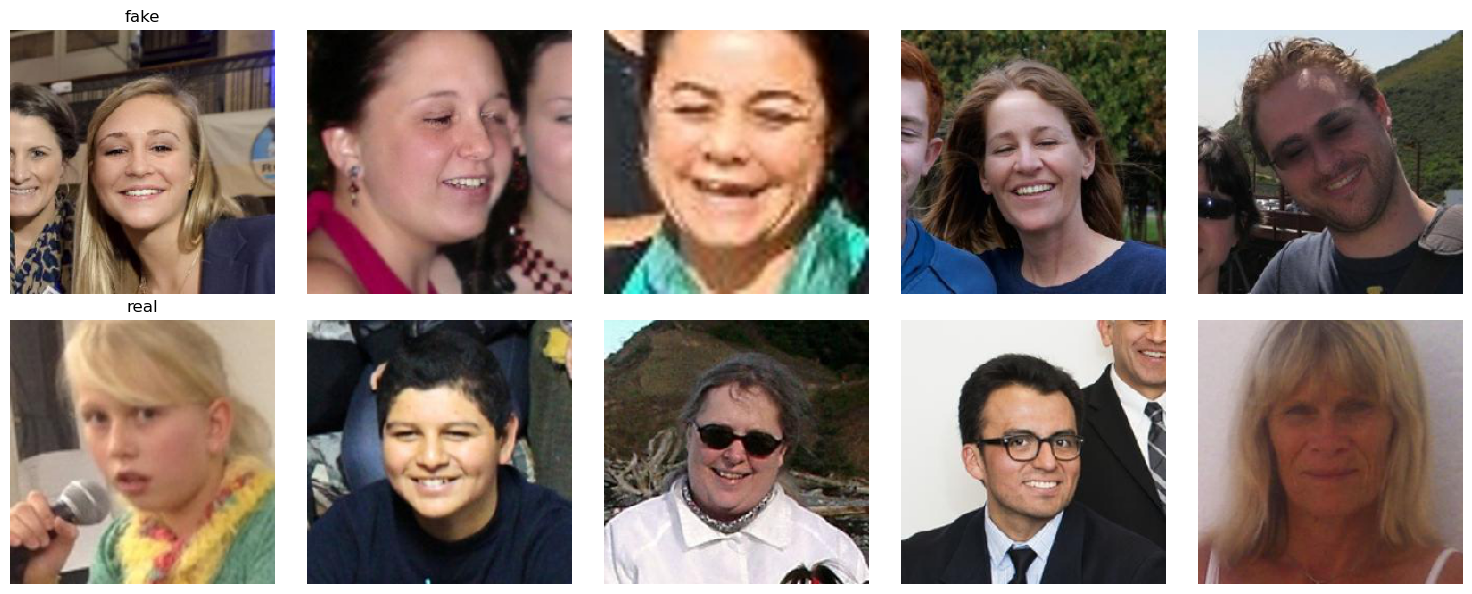

In [25]:
def display_sample_images(directory, num_samples=5):
    class_names, _ = get_class_counts(directory)
    if not class_names:
        print("No classes found in the directory.")
        return

    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, len(class_names) * 3))
    axes = axes.flatten() if len(class_names) > 1 else [axes]

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        sample_images = [img.name for img in os.scandir(class_dir) if img.is_file()][:num_samples]

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(224, 224))
            ax = axes[i * num_samples + j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, fontsize=12)

    plt.tight_layout()

display_sample_images(data_directories["train"])

### Basic Statistics

In [26]:
# Function to get basic dataset statistics
def get_dataset_statistics(directory, dataset_name):
    class_names, class_counts = get_class_counts(directory)
    total_images = sum(class_counts)
    stats = {
        'Class': class_names + [f'Total_{dataset_name}'],
        'Count': class_counts + [total_images],
        'Dataset': [dataset_name] * len(class_names) + [dataset_name]
    }
    return pd.DataFrame(stats)

# Get dataset statistics for each dataset and display as table
all_stats = []
for name, directory in data_directories.items():
    stats_df = get_dataset_statistics(directory, name)
    all_stats.append(stats_df)

combined_stats_df = pd.concat(all_stats, ignore_index=True)
pivot_table = combined_stats_df.pivot(index='Class', columns='Dataset', values='Count').fillna(0)
display(pivot_table)

Dataset        test    train      val
Class                                
Total_test   5227.0      0.0      0.0
Total_train     0.0  40002.0      0.0
Total_val       0.0      0.0  12360.0
fake         2623.0  20001.0   6161.0
real         2604.0  20001.0   6199.0

### Image Size Distribution

In [27]:
# Analyze the distribution of image sizes in your dataset to understand if there are any significant variations.

def analyze_image_sizes(directory):
    image_sizes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    image_sizes.append(img.shape[:2])  # (height, width)
    
    heights, widths = zip(*image_sizes)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=30, color='blue', alpha=0.7)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=30, color='green', alpha=0.7)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Analyze image sizes in the training directory
analyze_image_sizes(data_directories["train"])

### Aspect Ratio Distribution

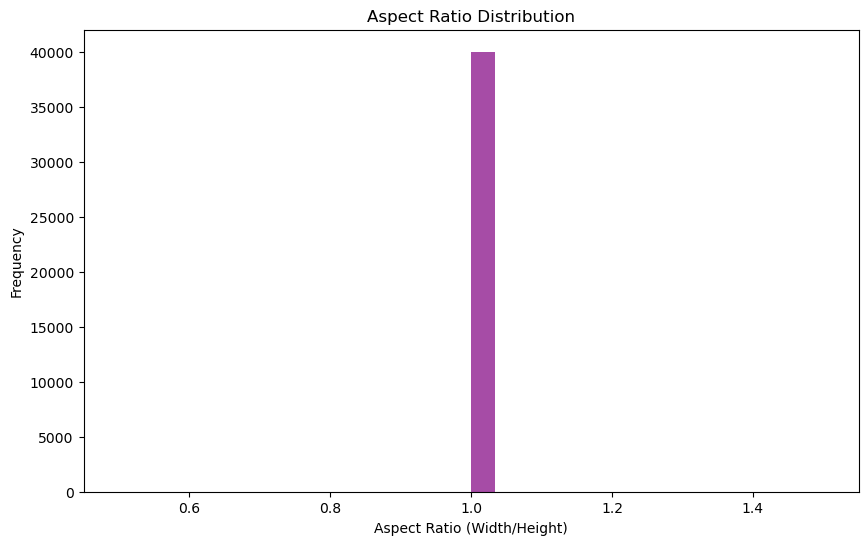

In [28]:
# Analyze the aspect ratio of images to understand if there are any common patterns.

def analyze_aspect_ratios(directory):
    aspect_ratios = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    height, width = img.shape[:2]
                    aspect_ratios.append(width / height)
    
    plt.figure(figsize=(10, 6))
    plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.show()

# Analyze aspect ratios in the training directory
analyze_aspect_ratios(data_directories["train"])

### Contrast Distribution

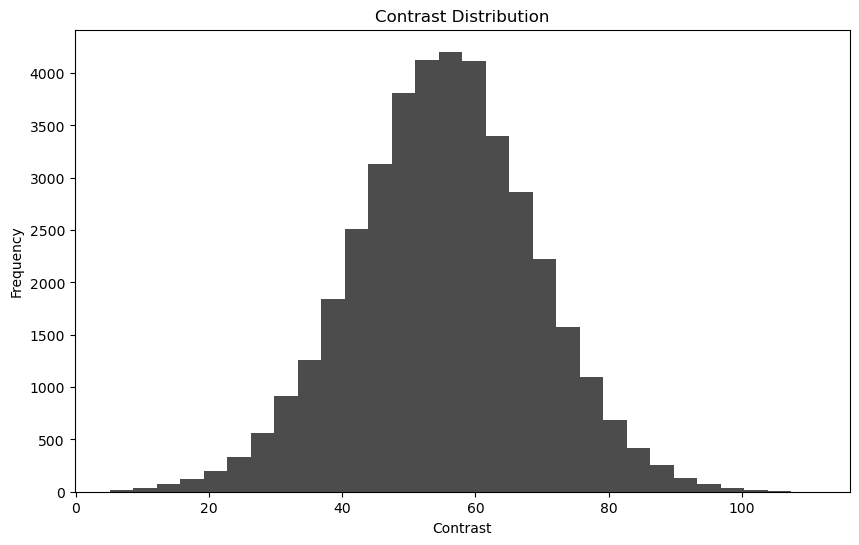

In [29]:
# Analyze the contrast distribution of images to understand the overall contrast levels.

def analyze_contrast_distribution(directory):
    contrast_values = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    contrast_values.append(np.std(gray_img))
    
    plt.figure(figsize=(10, 6))
    plt.hist(contrast_values, bins=30, color='black', alpha=0.7)
    plt.title('Contrast Distribution')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')
    plt.show()

# Analyze contrast distribution in the training directory
analyze_contrast_distribution(data_directories["train"])

### Image Brightness Distribution

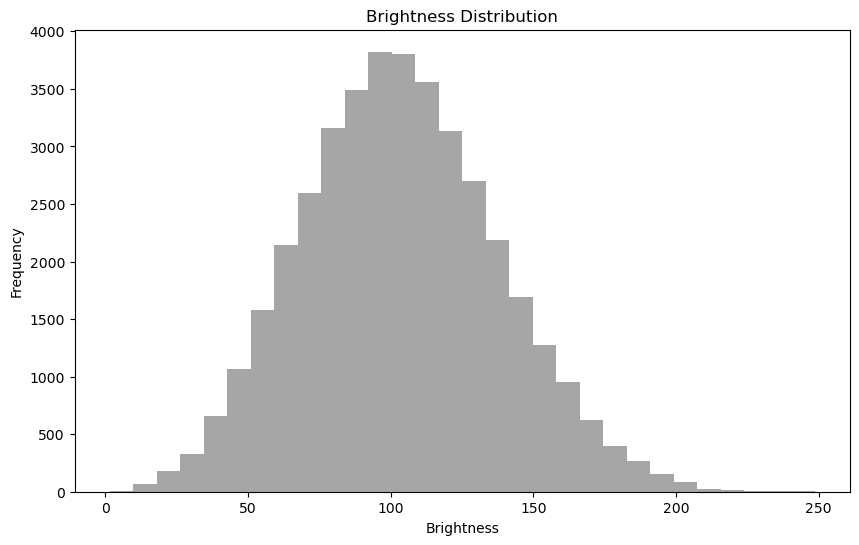

In [30]:
# Analyze the brightness distribution of images to understand the overall lighting conditions.

def analyze_brightness_distribution(directory):
    brightness_values = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    brightness_values.append(np.mean(gray_img))
    
    plt.figure(figsize=(10, 6))
    plt.hist(brightness_values, bins=30, color='gray', alpha=0.7)
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')
    plt.show()

# Analyze brightness distribution in the training directory
analyze_brightness_distribution(data_directories["train"])

# Preprocessing

In [31]:
# Set parameters for image preprocessing
image_size = (150, 150)
batch_size = 32

# Custom ImageDataGenerator with histogram equalization
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        generator = super().flow_from_directory(*args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            # Apply histogram equalization to each image in the batch
            batch_x = np.array([equalize_image(img) for img in batch_x])
            yield batch_x, batch_y

# Function for histogram equalization
def equalize_image(image):
    # Convert image to LAB color space, equalize the L-channel, then convert back to RGB
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # The L channel is assumed to be normalized (0-1) so we scale to 0-255 first
    l_eq = cv2.equalizeHist((l * 255).astype(np.uint8))
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

# Helper function to create ImageDataGenerators
def create_data_generators(train_dir, val_dir, test_dir, custom_augmentation=False):
    # Use the custom ImageDataGenerator if custom_augmentation is True
    if custom_augmentation:
        datagen_class = CustomImageDataGenerator
    else:
        datagen_class = ImageDataGenerator

    train_datagen = datagen_class(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    # For validation and testing, only rescaling is applied
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False,
    )

    return train_generator, val_generator, test_generator

# Function to display preprocessed images from a generator
def display_preprocessed_images(generator, num_samples=5):
    plt.figure(figsize=(10, 10))
    img_batch, label_batch = next(generator)
    for i in range(min(num_samples, len(img_batch))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_batch[i])
        plt.title(f"Label: {label_batch[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Function to extract HOG features from an image
def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    hog_features = hog(
        gray_image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=False,
    )
    return hog_features

# Function to load images from a folder and extract HOG features
def load_images_and_extract_features(folder, valid_extensions=None):
    if valid_extensions is None:
        valid_extensions = [".jpg", ".jpeg", ".png", ".bmp"]

    features, labels = [], []
    for filename in os.listdir(folder):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            img_path = os.path.join(folder, filename)
            img = io.imread(img_path)
            if img is not None:
                features.append(extract_hog_features(img))
                labels.append(filename.split("_")[0])  # Assumes filename format "label_image.jpg"
        else:
            print(f"Skipped file: {filename}")

    return np.array(features), np.array(labels)

### Displaying Preprocessed Images

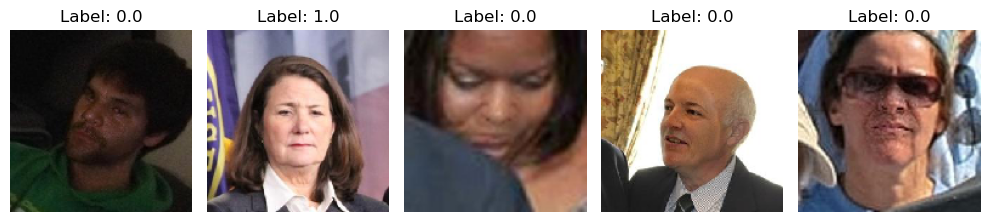

In [32]:
# Display preprocessed images from training set
display_preprocessed_images(generators["train"])

### Extracting HOG features

In [33]:
# Load images and extract HOG features from the training directory
train_features, train_labels = load_images_and_extract_features(data_directories["train"])

Skipped file: fake
Skipped file: real


### Flattening and Standard Scaling

In [34]:
# If necessary, flatten the features and apply standard scaling
def preprocess_features(features, flatten=False, scale=True):
    if flatten:
        features = features.reshape(features.shape[0], -1)
    if scale:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    return

## Feature Extraction

In [35]:
# Function to load images and labels
def load_images_and_labels(dataset_dir, target_size=(64, 64), classes=['real', 'fake']):
    images, labels = [], []
    for label in classes:
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                img = load_img(img_path, target_size=target_size)
                images.append(img_to_array(img))
                labels.append(label)
    return np.array(images), np.array(labels)

# Function to flatten image data
def flatten_images(images):
    return images.reshape(images.shape[0], -1)

# Function to plot explained variance by PCA components
def plot_explained_variance(pca, threshold=0.95):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold * 100)}% Variance Threshold')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot t-SNE results
def plot_tsne(X_tsne, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of PCA-Reduced Image Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid()
    plt.show()

# Load dataset
dataset_dir = data_directories["train"]  # Use predefined directory
images, labels = load_images_and_labels(dataset_dir)

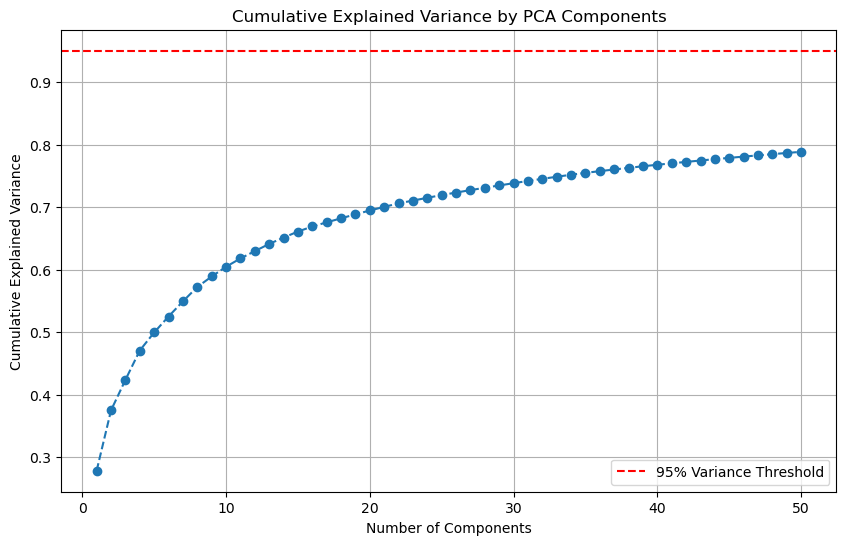

In [36]:
# Load images and labels
X, y = load_images_and_labels(dataset_dir, target_size=(64, 64), classes=classes)

# Flatten the image data
X_flat = flatten_images(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_flat)

# Plot explained variance
plot_explained_variance(pca)

## Model Building

In [37]:
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [42]:
# Function to create models
def create_model(model_type):
    if model_type == "custom_cnn":
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(150, 150, 3)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Flatten(),
            Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
    elif model_type == "inception":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False
    elif model_type == "mobilenet":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduce learning rate
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_metric]
    )
    return model

In [43]:
# Function to train models with ModelCheckpoint
def train_model(model, train_gen, val_gen, model_name):
    checkpoint_callback = ModelCheckpoint(
        filepath=f'{model_name}_best_model.h5',  # Saves the best model
        monitor='val_accuracy',  # Tracks validation accuracy
        save_best_only=True,  # Saves only the best version
        mode='max',
        verbose=1
    )

    print(f"Training {model_name} for 10 epochs...")
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = val_gen.samples // val_gen.batch_size

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[checkpoint_callback]  # Saves best model during training
    )

    return history

In [44]:
# Create and train models with checkpoints
custom_cnn_model = create_model("custom_cnn")
cnn_history = train_model(custom_cnn_model, generators['train'], generators['val'], "Custom_CNN")

inception_model = create_model("inception")
inception_history = train_model(inception_model, generators['train'], generators['val'], "InceptionV3")

mobilenet_model = create_model("mobilenet")
mobilenet_history = train_model(mobilenet_model, generators['train'], generators['val'], "MobileNetV2")

Training Custom_CNN for 10 epochs...
Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.9075 - accuracy: 0.7469 - precision_1: 0.7261 - recall_1: 0.7931 - f1_metric: 0.7513
Epoch 1: val_accuracy improved from -inf to 0.80724, saving model to Custom_CNN_best_model.h5
1250/1250 [==============================] - 1914s 2s/step - loss: 0.9075 - accuracy: 0.7469 - precision_1: 0.7261 - recall_1: 0.7931 - f1_metric: 0.7513 - val_loss: 0.6710 - val_accuracy: 0.8072 - val_precision_1: 0.7440 - val_recall_1: 0.9387 - val_f1_metric: 0.8270
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.8805 - precision_1: 0.8706 - recall_1: 0.8940 - f1_metric: 0.8780
Epoch 2: val_accuracy improved from 0.80724 to 0.87808, saving model to Custom_CNN_best_model.h5
1250/1250 [==============================] - 945s 756ms/step - loss: 0.5621 - accuracy: 0.8805 - precision_1: 0.8706 - recall_1: 0.8940 - f1_metric: 0.8780 - val_loss: 0.5551 - val_accu

## Evaluation

In [ ]:
# Load the best models saved during training
models = {
    "Custom_CNN": load_model("Custom_CNN_best_model.h5", custom_objects={"f1_metric": f1_metric}),
    "InceptionV3": load_model("InceptionV3_best_model.h5", custom_objects={"f1_metric": f1_metric}),
    "MobileNetV2": load_model("MobileNetV2_best_model.h5", custom_objects={"f1_metric": f1_metric})
}


### Evaluate on Test Set for Each Model

In [53]:
# Define test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create test generator
test_gen = test_datagen.flow_from_directory(
    data_directories["test"],  # Ensure this path exists and contains images
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary",
    shuffle=False  # Keep the order fixed for accurate evaluation
)

def evaluate_model(model, test_gen, model_name):
    """Evaluates a model on the test set."""
    test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_gen, verbose=1)

    print(f"\n📌 Model: {model_name}")
    print(f"🔹 Test Loss: {test_loss:.4f}")
    print(f"🔹 Test Accuracy: {test_acc:.4f}")
    print(f"🔹 Test Precision: {test_precision:.4f}")
    print(f"🔹 Test Recall: {test_recall:.4f}")
    print(f"🔹 Test F1 Score: {test_f1:.4f}")

# Run evaluation for all models
for model_name, model in models.items():
    evaluate_model(model, test_gen, model_name)

Found 5227 images belonging to 2 classes.
164/164 [==============================] - 36s 214ms/step - loss: 0.7959 - accuracy: 0.7808 - precision_1: 0.8055 - recall_1: 0.7381 - f1_metric: 0.4224

📌 Model: Custom_CNN
🔹 Test Loss: 0.7959
🔹 Test Accuracy: 0.7808
🔹 Test Precision: 0.8055
🔹 Test Recall: 0.7381
🔹 Test F1 Score: 0.4224
164/164 [==============================] - 159s 936ms/step - loss: 0.5536 - accuracy: 0.7415 - precision_2: 0.8112 - recall_2: 0.6271 - f1_metric: 0.3836

📌 Model: InceptionV3
🔹 Test Loss: 0.5536
🔹 Test Accuracy: 0.7415
🔹 Test Precision: 0.8112
🔹 Test Recall: 0.6271
🔹 Test F1 Score: 0.3836
164/164 [==============================] - 82s 477ms/step - loss: 0.6936 - accuracy: 0.6971 - precision_3: 0.8304 - recall_3: 0.4927 - f1_metric: 0.3261

📌 Model: MobileNetV2
🔹 Test Loss: 0.6936
🔹 Test Accuracy: 0.6971
🔹 Test Precision: 0.8304
🔹 Test Recall: 0.4927
🔹 Test F1 Score: 0.3261


### Plot Training History for Each Model

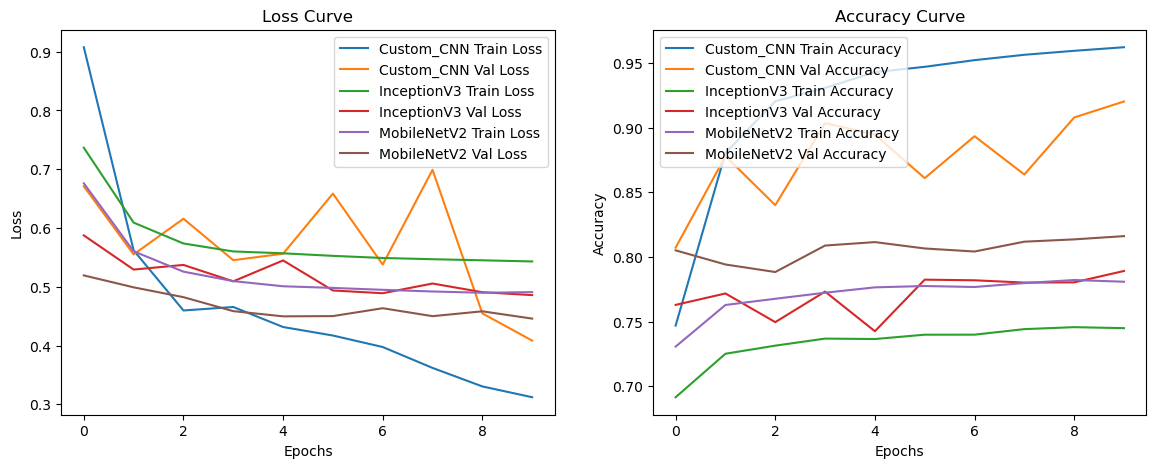

In [54]:
def plot_training_history(histories):
    """Plot training & validation loss and accuracy for all models."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for model_name, history in histories.items():
        axes[0].plot(history.history["loss"], label=f"{model_name} Train Loss")
        axes[0].plot(history.history["val_loss"], label=f"{model_name} Val Loss")
        
        axes[1].plot(history.history["accuracy"], label=f"{model_name} Train Accuracy")
        axes[1].plot(history.history["val_accuracy"], label=f"{model_name} Val Accuracy")

    axes[0].set_title("Loss Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].set_title("Accuracy Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.show()

# Call function with training histories
plot_training_history({"Custom_CNN": cnn_history, "InceptionV3": inception_history, "MobileNetV2": mobilenet_history})

### Generate Predictions and Compute Metrics: Classification Report

In [ ]:
def evaluate_predictions(model, test_gen, model_name):
    """Generate predictions and compute confusion matrix, classification report, and ROC curve."""
    # Get true labels & predictions
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    y_pred = np.round(y_pred_probs)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n📌 Model: {model_name}")
    print("🔹 Classification Report:\n", classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))
    
    return y_true, y_pred_probs, y_pred, cm

# Store results for all models
results = {}
for model_name, model in models.items():
    results[model_name] = evaluate_predictions(model, test_gen, model_name)

164/164 [==============================] - 36s 221ms/step

📌 Model: Custom_CNN
🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.82      0.79      2623
    Positive       0.81      0.74      0.77      2604

    accuracy                           0.78      5227
   macro avg       0.78      0.78      0.78      5227
weighted avg       0.78      0.78      0.78      5227

164/164 [==============================] - 142s 837ms/step

📌 Model: InceptionV3
🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.86      0.77      2623
    Positive       0.81      0.63      0.71      2604

    accuracy                           0.74      5227
   macro avg       0.75      0.74      0.74      5227
weighted avg       0.75      0.74      0.74      5227

164/164 [==============================] - 78s 457ms/step

📌 Model: MobileNetV2
🔹 Classification Report:
               precision    r

### Plot Confusion Matrices

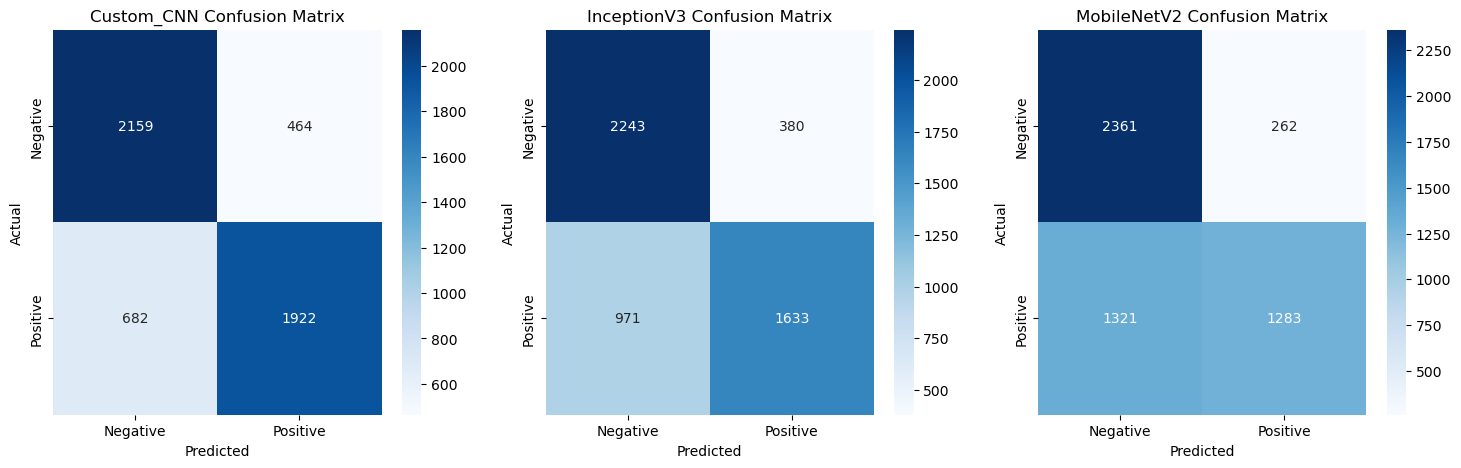

In [57]:
def plot_confusion_matrices(results):
    """Plot confusion matrices for all models."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (model_name, (y_true, y_pred_probs, y_pred, cm)) in enumerate(results.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], ax=axes[i])
        axes[i].set_title(f"{model_name} Confusion Matrix")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    
    plt.show()

# Call function
plot_confusion_matrices(results)

### Plot ROC Curves

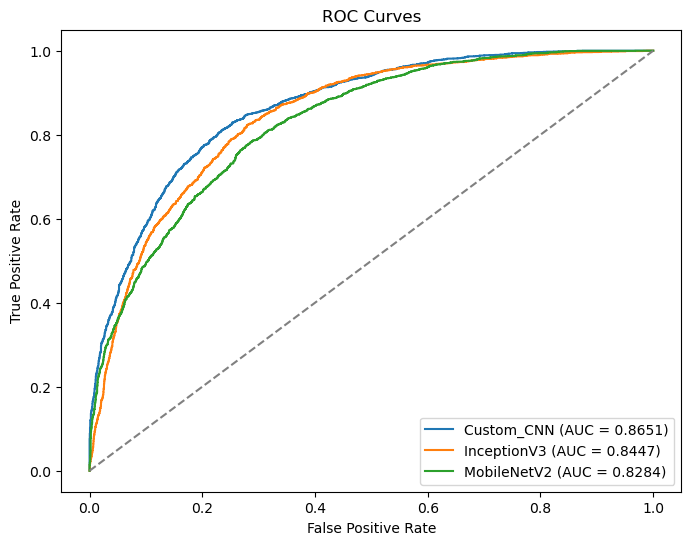

In [58]:
def plot_roc_curves(results):
    """Plot ROC curves for all models."""
    plt.figure(figsize=(8, 6))
    
    for model_name, (y_true, y_pred_probs, _, _) in results.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()

# Call function
plot_roc_curves(results)

In [60]:
# Ensure predictions match the number of test samples
pred_probs = model.predict(test_gen, verbose=1)  # Get predicted probabilities
pred_labels = (pred_probs > 0.5).astype(int).flatten()  # Convert to binary labels
true_labels = test_gen.classes  # Get true labels

print(f"Number of test samples: {len(true_labels)}")
print(f"Number of predictions: {len(pred_labels)}")

# Ensure array lengths match
assert len(pred_labels) == len(true_labels), "Mismatch between predictions and true labels!"

164/164 [==============================] - 63s 382ms/step
Number of test samples: 5227
Number of predictions: 5227


### Show Misclassified Images

In [64]:
# Ensure predictions match the number of test samples
pred_probs = model.predict(test_gen, verbose=1)  # Get predicted probabilities
pred_labels = (pred_probs > 0.5).astype(int).flatten()  # Convert to binary labels
true_labels = test_gen.classes  # Get true labels

print(f"Number of test samples: {len(true_labels)}")
print(f"Number of predictions: {len(pred_labels)}")

# Ensure array lengths match
assert len(pred_labels) == len(true_labels), "Mismatch between predictions and true labels!"

164/164 [==============================] - 32s 193ms/step
Number of test samples: 5227
Number of predictions: 5227


164/164 [==============================] - 32s 192ms/step
Total misclassified images: 1146


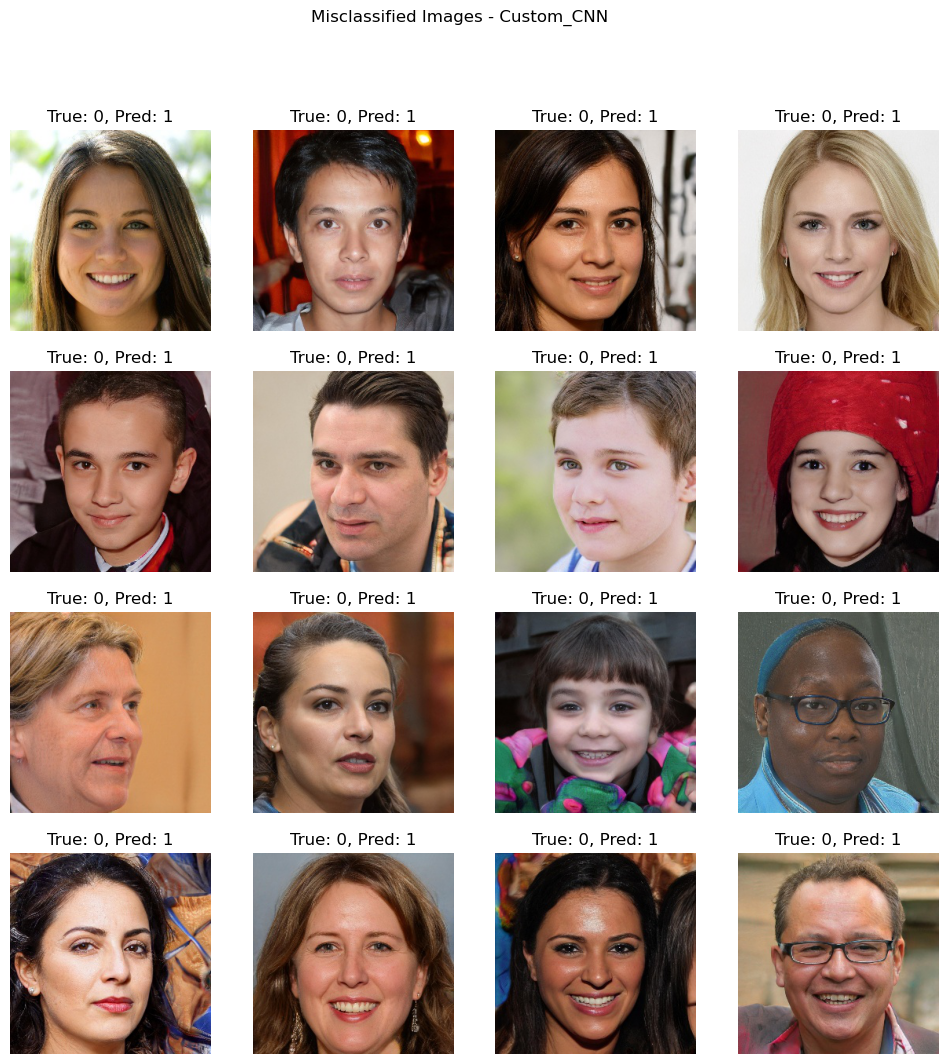

164/164 [==============================] - 110s 671ms/step
Total misclassified images: 1351


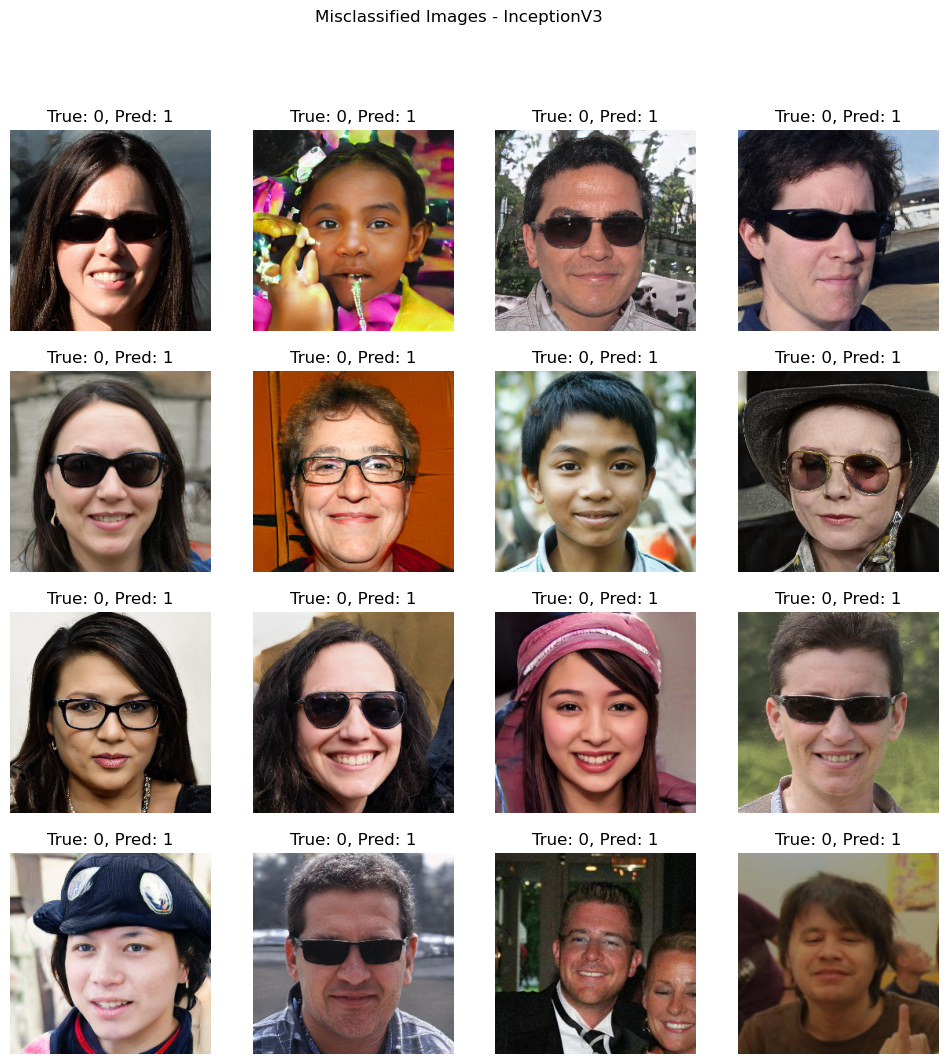

164/164 [==============================] - 62s 376ms/step
Total misclassified images: 1583


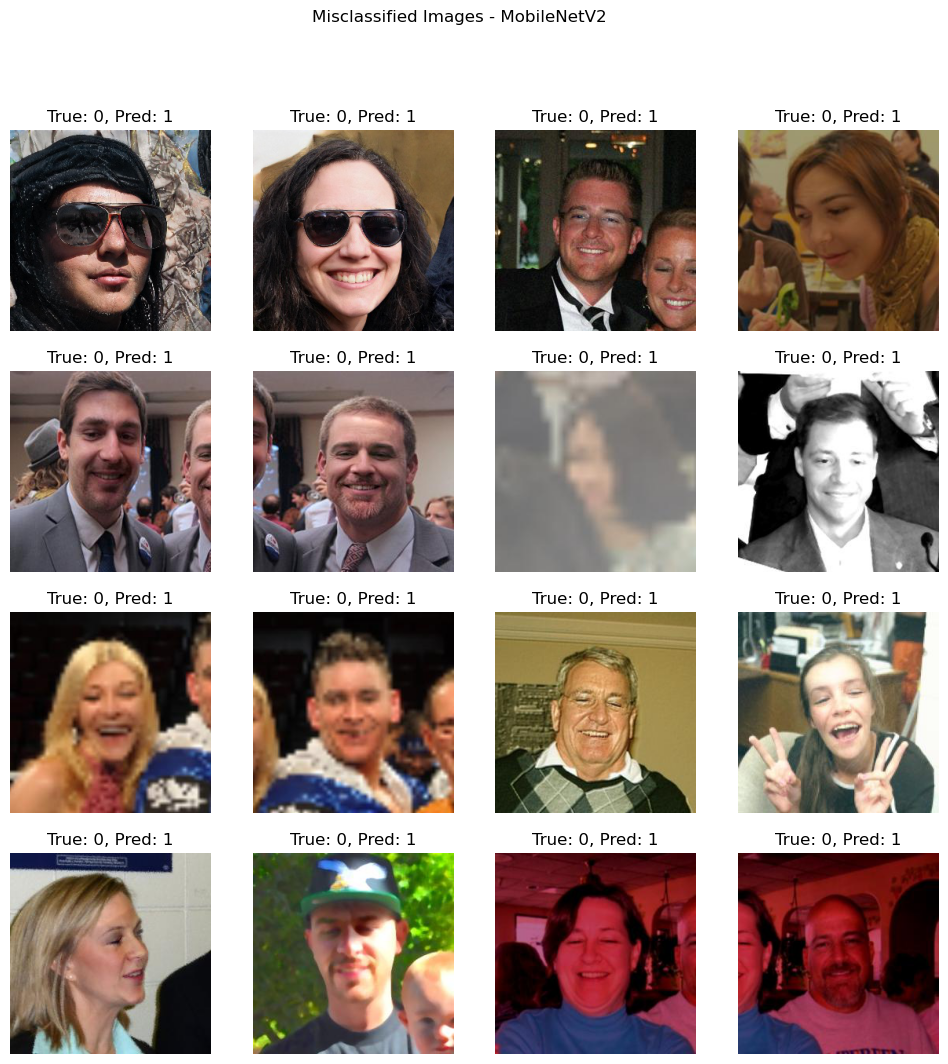

In [65]:
def plot_misclassified_images(test_gen, results, model_name):
    true_labels = test_gen.classes
    pred_probs = results  # Assuming `results` is a list of predicted probabilities
    pred_labels = (pred_probs > 0.5).astype(int).flatten()

    # Find misclassified indices
    misclassified_indices = np.where(true_labels != pred_labels)[0]
    print(f"Total misclassified images: {len(misclassified_indices)}")

    # Limit number of images to prevent out-of-bounds errors
    num_images = min(16, len(misclassified_indices))  # Show up to 16 images safely

    if num_images == 0:
        print(f"No misclassified images for {model_name}.")
        return

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Create 4x4 grid
    axes = axes.flatten()

    for i in range(num_images):
        idx = misclassified_indices[i]
        img_path = test_gen.filepaths[idx]  # Get image path safely
        img = plt.imread(img_path)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {true_labels[idx]}, Pred: {pred_labels[idx]}")

    plt.suptitle(f"Misclassified Images - {model_name}")
    plt.show()

# Display misclassified images for each model
for model_name, model in models.items():
    pred_probs = model.predict(test_gen)  # Get predictions
    plot_misclassified_images(test_gen, pred_probs, model_name)

## Validating best Trained Model

In [71]:
# Function to preprocess the uploaded image
def preprocess_image(image_path, target_size=(150, 150)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to load the trained model
def load_trained_model(model_path):
    return tf.keras.models.load_model(model_path, custom_objects={'f1_metric': f1_metric})

# Function to classify the uploaded image
def classify_image(image_path, model):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    class_label = 'fake' if prediction[0] < 0.5 else 'real'
    confidence = 1 - prediction[0] if class_label == 'fake' else prediction[0]
    return class_label, confidence

# Example usage
model_path = 'Custom_CNN_best_model.h5'  # Replace with the path to your trained model
uploaded_image_path = r'C:\Users\TinoL\OneDrive\Desktop\1.png'  # Replace with the path to the uploaded image

# Load the trained model
model = load_trained_model(model_path)

# Classify the uploaded image
class_label, confidence = classify_image(uploaded_image_path, model)

# Display the result
print(f'The uploaded image is classified as {class_label} with a confidence of {confidence[0]:.2f}')

1/1 [==============================] - 0s 356ms/step
The uploaded image is classified as fake with a confidence of 0.99
